Week 7 · Day 3 — Building a Clean PyTorch CNN
Why this matters

CNN experiments get messy fast. Having a reusable, structured training loop and a clean CNN module helps you scale to bigger models and datasets without rewriting code every time.

Theory Essentials

nn.Conv2d: defines convolutional layers with channels, kernel size, stride, padding.

nn.ReLU / nn.MaxPool2d: introduce nonlinearity and reduce size.

nn.Flatten: flattens feature maps into vectors for fully connected layers.

Modular training loop: separate train_one_epoch and evaluate functions.

Seed control: reproducibility matters in ML experiments.

In [1]:
# Setup
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

torch.manual_seed(42)

# ---------- Data ----------
transform = transforms.Compose([transforms.ToTensor()])
dataset = datasets.FashionMNIST(root="data", train=True, download=True, transform=transform)
train_data, val_data = random_split(dataset, [50000, 10000])
train_loader = DataLoader(train_data, batch_size=128, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=256)

# ---------- Model ----------
class CleanCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# ---------- Training Utilities ----------
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    for X,y in loader:
        X,y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0,0,0
    with torch.no_grad():
        for X,y in loader:
            X,y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            total_loss += loss.item()
            preds = out.argmax(dim=1)
            correct += (preds==y).sum().item()
            total += y.size(0)
    acc = correct / total
    return total_loss/len(loader), acc

# ---------- Train/Eval ----------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CleanCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(3):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}: Train loss {train_loss:.3f} | Val loss {val_loss:.3f} | Val acc {val_acc:.3f}")


Epoch 1: Train loss 0.552 | Val loss 0.371 | Val acc 0.863
Epoch 2: Train loss 0.343 | Val loss 0.341 | Val acc 0.873
Epoch 3: Train loss 0.293 | Val loss 0.291 | Val acc 0.895



## 🔹 `nn.Linear` (MLP fully connected)

* **Usage:** `nn.Linear(in_features, out_features)`
* Example: `nn.Linear(28*28, 256)`
  → Each input pixel is connected to each neuron in the next layer.
* **Meaning:**

  * `in_features` = number of inputs per neuron.
  * `out_features` = number of neurons in that layer.
* Problem for images: **ignores spatial structure** (treats pixels as a flat list).

---

## 🔹 `nn.Conv2d` (convolutional layer)

* **Usage:** `nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0)`
* Example: `nn.Conv2d(1, 32, 3, padding=1)`

  * `in_channels=1`: grayscale input (1 channel).
  * `out_channels=32`: this layer will **learn 32 filters** → output 32 feature maps.
  * `kernel_size=3`: each filter is a **3×3 patch** that slides over the image.
  * `padding=1`: adds a border so the output stays the same size (28×28 → 28×28).
* **Meaning:**
  Each output pixel is a weighted combination of a **local neighborhood** (like 3×3 region).
  Instead of fully connecting everything, we only look at nearby pixels, and we reuse the same filter everywhere in the image.

---

## 🔹 Why CNNs use Conv2d instead of Linear

* **Locality:** Conv filters look at small regions (edges, textures).
* **Weight sharing:** Same filter slides over the whole image → far fewer parameters.
* **Translation invariance:** a “stroke” detected in one corner can also be recognized in another.

---

## 🔹 Where pooling & flatten fit

* **`nn.MaxPool2d(2)`**: halves the spatial size (28→14, 14→7). Keeps strongest activations.
* **`nn.Flatten()`**: after convolutions, you have shape (batch, channels, height, width). Flatten turns it into (batch, features) so you can pass it into `nn.Linear`.

---

## 🔹 Why Linear shows up again

At the **end of the CNN**, you’ve got extracted features (say `64×7×7 = 3136` numbers).
You still need a classifier → `nn.Linear(3136, 128)` → `nn.Linear(128, 10)`.

So:

* **Conv2d layers** = feature extractors (edges → textures → patterns).
* **Linear layers** = classifier head (map features → class probabilities).

---

1) Core (10–15 min)

Task: Add nn.Dropout(0.5) before the final linear layer.

In [ ]:
class CleanCNNDrop(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.classifier(self.features(x))
    

model_drop = CleanCNNDrop().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(3):
    train_loss = train_one_epoch(model_drop, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model_drop, val_loader, criterion, device)
    print(f"Epoch {epoch+1}: Train loss {train_loss:.3f} | Val loss {val_loss:.3f} | Val acc {val_acc:.3f}")

Epoch 1: Train loss 0.622 | Val loss 0.391 | Val acc 0.855
Epoch 2: Train loss 0.386 | Val loss 0.332 | Val acc 0.878
Epoch 3: Train loss 0.332 | Val loss 0.298 | Val acc 0.890


Dropout here reduces the accuracy slightly. I first tried with 0.5 but the result was worst.

If train acc is low and val acc is also low → you’re underfitting. Dropout makes it worse. Reduce p or remove it; train more epochs.

If train acc is high but val acc is much lower → you’re overfitting. Dropout (or weight decay/aug) can help; maybe increase p a bit.

2) Practice (10–15 min)

Task: Replace Adam with SGD(lr=0.01, momentum=0.9) and compare validation accuracy.

In [4]:
optimizer_sgd = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)

for epoch in range(3):
    train_loss = train_one_epoch(model, train_loader, optimizer_sgd, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch+1}: Train loss {train_loss:.3f} | Val loss {val_loss:.3f} | Val acc {val_acc:.3f}")

Epoch 1: Train loss 0.289 | Val loss 0.274 | Val acc 0.897
Epoch 2: Train loss 0.283 | Val loss 0.272 | Val acc 0.898
Epoch 3: Train loss 0.280 | Val loss 0.272 | Val acc 0.899


SGD + momentum does slightly in these conditionsa dn data set.

3) Stretch (optional, 10–15 min)

Task: Add an argument num_classes to CleanCNN so the model works on any dataset.

In [ ]:
class FlexibleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.classifier(self.features(x))


Can't really try out as both data sets I use(digit and fashion) contain 10 classes, which was the number of classes in the original CNN.

Mini-Challenge (≤40 min)

Task:

Train CleanCNN for 10 epochs.

Track train loss, val loss, val accuracy per epoch.

Plot curves (loss & accuracy).

Acceptance Criteria:

At least 2 plots (loss + accuracy).

Short note on whether the model underfits, overfits, or looks balanced.

Epoch 01 | train_loss=0.5560 | val_loss=0.3763 | val_acc=0.8641
Epoch 02 | train_loss=0.3401 | val_loss=0.3131 | val_acc=0.8844
Epoch 03 | train_loss=0.2888 | val_loss=0.3032 | val_acc=0.8879
Epoch 04 | train_loss=0.2597 | val_loss=0.2694 | val_acc=0.9003
Epoch 05 | train_loss=0.2374 | val_loss=0.2544 | val_acc=0.9052
Epoch 06 | train_loss=0.2192 | val_loss=0.2524 | val_acc=0.9060
Epoch 07 | train_loss=0.2036 | val_loss=0.2348 | val_acc=0.9142
Epoch 08 | train_loss=0.1924 | val_loss=0.2263 | val_acc=0.9171
Epoch 09 | train_loss=0.1771 | val_loss=0.2216 | val_acc=0.9209
Epoch 10 | train_loss=0.1629 | val_loss=0.2126 | val_acc=0.9215
Total time: 418.5s


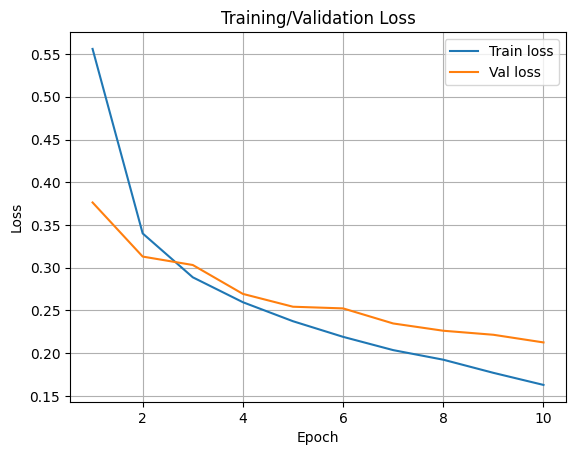

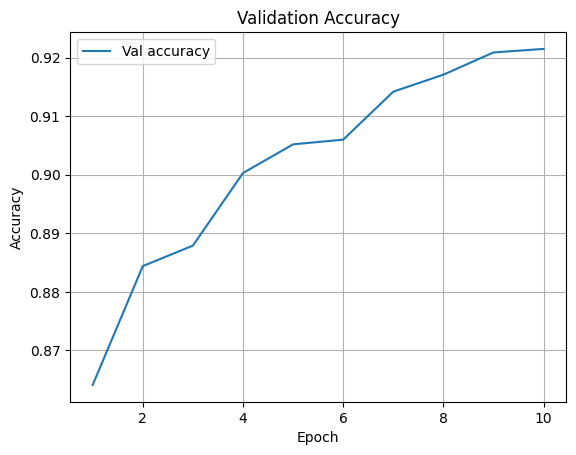

In [5]:
# --- Training CleanCNN for 10 epochs with curves ---

import time
import torch, torch.nn as nn, torch.optim as optim
import matplotlib.pyplot as plt

torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# (Re)define CleanCNN exactly as you had it
class CleanCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*7*7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        return self.classifier(self.features(x))

# --- Utilities (same signatures you used) ---
def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0.0
    for X, y in loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / max(1, len(loader))

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for X, y in loader:
            X, y = X.to(device), y.to(device)
            out = model(X)
            loss = criterion(out, y)
            total_loss += loss.item()
            preds = out.argmax(dim=1)
            correct += (preds == y).sum().item()
            total += y.size(0)
    acc = correct / total
    return total_loss / max(1, len(loader)), acc

# --- Instantiate & train ---
model = CleanCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 10
hist = {"train_loss": [], "val_loss": [], "val_acc": []}

start = time.time()
for ep in range(1, EPOCHS + 1):
    tr_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
    va_loss, va_acc = evaluate(model, val_loader, criterion, device)
    hist["train_loss"].append(tr_loss)
    hist["val_loss"].append(va_loss)
    hist["val_acc"].append(va_acc)
    print(f"Epoch {ep:02d} | train_loss={tr_loss:.4f} | val_loss={va_loss:.4f} | val_acc={va_acc:.4f}")
print(f"Total time: {time.time()-start:.1f}s")

# --- Plots: loss & accuracy ---
epochs = range(1, EPOCHS + 1)

plt.figure(); 
plt.plot(epochs, hist["train_loss"], label="Train loss")
plt.plot(epochs, hist["val_loss"],   label="Val loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Training/Validation Loss"); plt.legend(); plt.grid(True)
plt.show()

plt.figure(); 
plt.plot(epochs, hist["val_acc"], label="Val accuracy")
plt.xlabel("Epoch"); plt.ylabel("Accuracy"); plt.title("Validation Accuracy"); plt.legend(); plt.grid(True)
plt.show()


Model looks well balanced as train and val loss both drop at a similar rate while val accuracy keeps improving.

Notes / Key Takeaways

Structuring models + loops saves time later.

Modular train_one_epoch and evaluate = reusable for all future models.

CNNs naturally extend to more layers/filters.

Dropout and optimizer choice can significantly affect performance.

Reproducibility (seeds, fixed code structure) is key in ML.

Reflection

Why do we separate train and eval phases in PyTorch?

What advantages does a modular evaluate function give?

🔹 Why do we separate train and eval phases in PyTorch?

In train mode (model.train()), layers like Dropout and BatchNorm behave differently (dropout randomly zeros activations; batchnorm updates running stats).

In eval mode (model.eval()), those layers switch to inference behavior (dropout off, batchnorm uses fixed stats).

Separating phases ensures we train correctly (with regularization) and evaluate fairly (stable predictions).

🔹 What advantages does a modular evaluate function give?

Reusability: you can call it anytime (after each epoch, after training, or on a test set).

Cleaner code: no duplicate evaluation logic inside the training loop.

Flexibility: easy to extend (add accuracy, confusion matrix, F1) without touching the training code.

Fewer bugs: train loop only worries about updates; evaluate loop only worries about measuring.